# **Coleridge Initiative - Show US the Data**


The goal of this competition is to extract out the references to various studies/dataset that is embedded in the content. 

The approach followed is similar to that of a translation problem using an attention network. We provide the input text and the model has to provide an output text. In this case, the output text is the "references" in the text. 

This notebook uses a pretrained BERTTokenizer to generate the encoded tokens for the provided text and then uses a simple transformer model to generate an output that is also a sequence of BERTTokens.

To acheive this, we are going to do the following

* Preprocessing the data
    * Read the relevant content for each id.
    * chunk them into sizes of 500.
    * clean these chunks and BERTTokenize them. This will be the input to the transformer.
    * During training, we read the output dataset label
    * clean these and BERTTokenize them.
    * wrap these around [CLS] and [SEP] tokens. This will be the ouput for the transformer.
* Model and training the model
    * We create a simple pytorch network based on transformers.
    * we train the network using the inputs and outputs that we generated during pretraining
    * we use NLLLoss for backpropagation in the network.


This model provides a score of 0.532 during inference with the test data.
https://www.kaggle.com/sreejaej/colleridge-attention-inference/ 


In [ ]:
##
# Import the relevant libraries
##

import pandas as pd
import numpy as np
import json
import re
import torch.nn as nn 
import torch
from transformers import BertTokenizer
from nltk.corpus import stopwords
from tqdm import tqdm
import random



In [ ]:
##### # Set the constants that are used in the code 
##

DATA_PROCESSING_MODE = "PROCESS_TRAINING_DATA"
#DATA_PROCESSING_MODE = "USE_PREPROCESSED_TRAINING_DATA"

TRAINING_MODE = "TRAIN_FROM_SCRATCH"
#TRAINING_MODE = "USE_TRAINED_MODEL"

TRAIN_PATH = '../input/coleridgeinitiative-show-us-the-data/train.csv'
TRAIN_DATA_FOLDER = '../input/coleridgeinitiative-show-us-the-data/train'
TRAINING_BATCH_END_INDEX = 10000 
VAL_BATCH_START_INDEX = 10000  
VAL_BATCH_END_INDEX = 12000   

PREPROCESSED_TRAIN_PATH = "../input/colldata10-2/colleridge_processed_train-10.parquet"
PREPROCESSED_VAL_PATH ="../input/colldata10-2/colleridge_processed_val-10.parquet"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ = 200
OVERLAP=20
EMBEDDING_DIM = 200 
BATCH_SIZE = 8 
LEARNING_RATE=1e-3
EPOCHS = 15 

In [ ]:
##
# Read the data 
##
train = pd.read_csv(TRAIN_PATH)
train

## Data Preprocessing

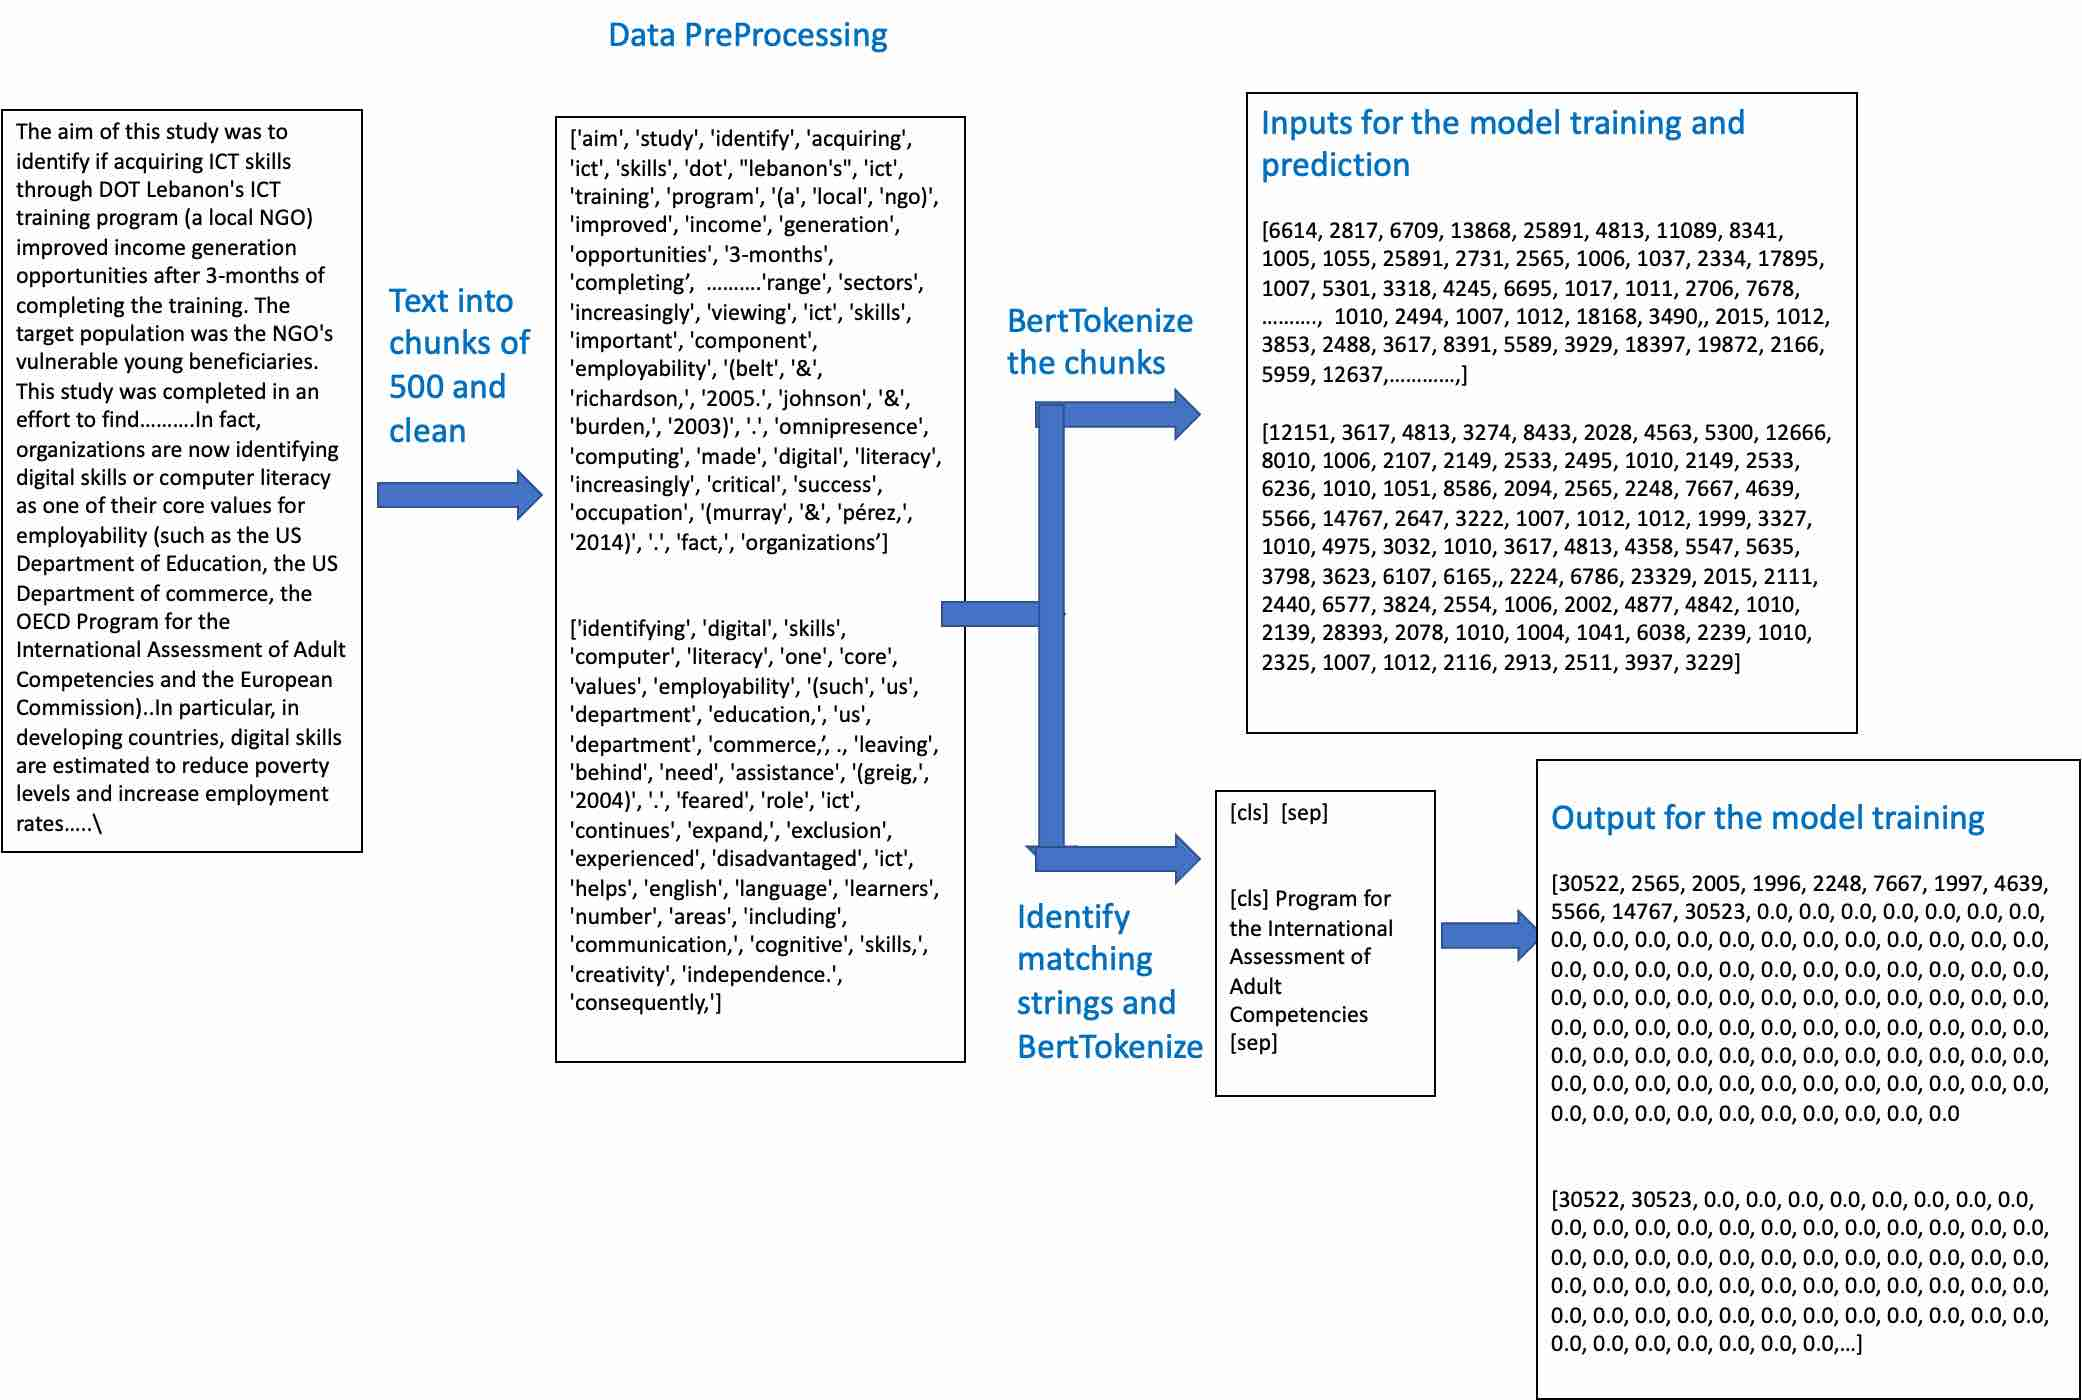

In [ ]:
train['cleaned_label'] = train['cleaned_label'].apply(lambda x : x.strip())


In [ ]:
#known_labels = np.unique( train['cleaned_label'] ) 

In [ ]:
'''for label in larger_label_set:
    ignore=False;
    for word in label.split():
        if word in ['study', 'data', 'dataset', 'database', 'survey', 'program', 'programs']:
            print(label)
            ignore=True;
            
    if( ignore==False):
        print("XXXX", label)'''
        
        
    

In [ ]:
'''with open(TRAIN_DATA_FOLDER+'/'+ '630de001-fa5b-4973-ba3f-52f6f1f4dc2d' +'.json', 'r') as f:
    #Load the json 
    paper = json.load(f)
    print(paper)
    #print( re.findall('\([A-Z]{4,}', paper[0].get('text')) ) '''

In [ ]:
larger_label_set = pd.read_csv("../input/bigger-govt-dataset-list/data_set_800.csv")
larger_label_set =np.unique(larger_label_set['title'].values )

In [ ]:
np.sort(larger_label_set)

In [ ]:
####
#
# This method is used to clean the input list of words.
#
####
stopwords_set = set(stopwords.words('english')) 
def clean_text(input_words):
    #return [ re.sub(' +', ' ', re.sub('[^A-Za-z0-9\[\]]+', ' ', str(r).lower()).strip()) for r in input_words if not r.lower() in stopwords_set  ]
    return [ re.sub(' +', ' ', re.sub('[^A-Za-z0-9\[\]]+', ' ', str(r).lower()).strip()) for r in input_words ]


def clean_text2(input_words):
    #return [ re.sub(' +', ' ', re.sub('[^A-Za-z0-9\[\]]+', ' ', str(r).lower()).strip()) for r in input_words if not r.lower() in stopwords_set  ]
    return [ re.sub(' +', ' ', re.sub('[^A-Za-z0-9\[\]\(\)]+', ' ', str(r).lower()).strip()) for r in input_words ]


####
#
# This method takes a single chunk of 'input words', cleans and tokenizes them using a tokenizer.  It also compares the input 
# for a set of "potential output string". If any of them match, the matches string is also tokenized with a wraping 
# [cls] [sep]. The tokenized input and output array is returned as the output. 
#
####
def tokenize_single_chunk(input_words, potential_output_strings, tokenizer):

    successfully_matched_string = "[cls] "
    
    matched_list = [] 
    
    for match_string in potential_output_strings:  
        if " ".join(clean_text(match_string.split())) not in " ".join(clean_text(input_words)):
            continue    
        matched_list.append(" ".join(clean_text(match_string.split())))

    for match_string1 in matched_list:
        successfully_matched_string = successfully_matched_string  +  match_string1    +  " [sep] "

    if (successfully_matched_string == "[cls] " ):
        successfully_matched_string = successfully_matched_string  +  " [sep] "
        
         
    encoded_input_word_list = clean_text2(input_words)
    encoded_input_word_list = list(map(tokenizer.convert_tokens_to_ids, tokenizer.tokenize ( " ".join(encoded_input_word_list)) ))
    

    if ( len(encoded_input_word_list) <= MAX_SEQ ):
        encoded_input_word_list = encoded_input_word_list + list(np.zeros( MAX_SEQ - len(encoded_input_word_list)) )
    else :
        encoded_input_word_list = encoded_input_word_list[0:MAX_SEQ]
    
    
    encoded_output_word_list = list(map(tokenizer.convert_tokens_to_ids, tokenizer.tokenize ( successfully_matched_string ) ))
    

    if ( len(encoded_output_word_list) < MAX_SEQ ):
        encoded_output_word_list = encoded_output_word_list +  list(np.zeros( MAX_SEQ - len(encoded_output_word_list)) )
    else:
        encoded_output_word_list = encoded_output_word_list[:MAX_SEQ]
        
    
    return encoded_input_word_list, encoded_output_word_list




####
#
# This method takes a dataframe with each row representing an id and 'output labels'. The corresponding text in the json is read  
# and converted into chunks of 450 (Tokenizer uses word piece that causes the count to increase so setting to 450. (Todo: Relook) ).
# Process each of these chunks and 'output labels' to create the input and ouputs needed to train the network. 
# This returns a dataframe with encoded inputs and ouput as each row (for each chunk )
# 
####
def process_data (df, tokenizer) :
    max_word_count = 0 
    text_array = [] 
    code_array=[]
     
    
    df_final = pd.DataFrame(columns = ['Id', 'text', 'code'])

    #words_in_cap=[]
    
    for index, id in tqdm ( enumerate ( df.index) )  :
        with open(TRAIN_DATA_FOLDER+'/'+ id +'.json', 'r') as f:
                #Load the json 
                paper = json.load(f)
                #print(id)
                #print(paper)
                
                #Convert the relevant sentences into a single paragraph
                section_sentences =[]

                for section_index in range ( 0, len(paper)):
                    #words_in_cap = words_in_cap + re.findall('[A-Z]{4,}', paper[section_index].get('text'))
                    section_sentences = section_sentences +  re.split('[.;\n•]',paper[section_index].get('text'))   
                section_sentences = "[sep]".join(section_sentences) 
                sentence_words = section_sentences.split() 
        
               
            
                # Chunk the paragraph into size of 500. Todo:Relook at this 
                n = int(0.7*MAX_SEQ)
                word_chunks = [sentence_words[i:i+n+OVERLAP]  for i in range(0, len(sentence_words), n)] 
                word_chunks[-1] = word_chunks[-1] + list(np.empty( MAX_SEQ - len(word_chunks[-1]), dtype=str) )
 
                     
                # Add the words in the labels to the output wordlist
                labels  = df[index]

                # Encode/Embed the words for processing
                df_new = pd.DataFrame(columns = ['Id', 'text', 'code','rseq_no'])
                chunk_count= len(word_chunks)
                for i in range ( 0, len(word_chunks)):
                    encoded_input_word_list, encoded_output_word_list = tokenize_single_chunk(word_chunks[i], larger_label_set, tokenizer )
                    df_temp = pd.DataFrame ({"Id":id, "text":[encoded_input_word_list], "code": [encoded_output_word_list], 'rseq_no':chunk_count- i}, index=[i])
                    df_new =df_new.append(df_temp, ignore_index=True)
                    #print(df_new)

        df_final = df_final.append(df_new, ignore_index=True)

    df_final['word_count'] = list( map ( (lambda i : len ( [ x for x in df_final.iloc[i]['code'] if x not in [30522, 30523, 0.0] ] ) ) , range(0, df_final.shape[0])) )

    '''words_in_cap = np.unique( words_in_cap)
    for cap_word in words_in_cap:
        print(cap_word)
        tokenizer.add_tokens(cap_word)'''
        
    return df_final

In [ ]:
##
# Group the data to obtain all the output labels for an id 
##

train['dataset_title'] = train['dataset_title'].apply ( lambda x: re.sub('[^A-Za-z0-9\[\]]+', ' ', str(x).lower()).strip() )
train['dataset_label'] = train['dataset_label'].apply ( lambda x:  re.sub('[^A-Za-z0-9\[\]]+', ' ', str(x).lower()).strip() )

'''train_new = train [['Id', 'dataset_title', 'dataset_label', 'cleaned_label']].groupby('Id').apply(lambda r: np.unique( list( r['dataset_label'].values) 
                                                                                +  list ( r['cleaned_label'].values) 
                                                                                + list ( r['dataset_title'].values )) )'''

train_new = train [['Id', 'dataset_title', 'dataset_label', 'cleaned_label']].groupby('Id').apply(lambda r: np.unique( list ( r['cleaned_label'].values) 
                                                                                ))
train_new

In [ ]:
#temp = list(map( lambda x : list(x), train_new)) 
known_labels = larger_label_set

In [ ]:
##
# Intialize a BERT Tokenizer and Process the input data and make it ready for training. 
# Create train and validataion ( Todo : do this using Cross Validation )
##

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer.add_tokens('[cls]')
tokenizer.add_tokens('[sep]')

if ( DATA_PROCESSING_MODE == 'PROCESS_TRAINING_DATA' ):
    df_train = process_data(train_new[:TRAINING_BATCH_END_INDEX], tokenizer)  
    df_train.to_parquet("colleridge_processed_train.parquet")

    df_val = process_data(train_new[VAL_BATCH_START_INDEX:VAL_BATCH_END_INDEX], tokenizer)  
    df_val.to_parquet("colleridge_processed_val.parquet")
    
else :
    df_train = pd.read_parquet (PREPROCESSED_TRAIN_PATH)
    df_val = pd.read_parquet(PREPROCESSED_VAL_PATH)
    df_train = df_train.append(df_val)

    

In [ ]:
vocab_len= 30522 + len( tokenizer.get_added_vocab() )
vocab_len

In [ ]:
#df_tx = df_train.groupby('Id').apply( lambda row: sum(row['word_count'])) 
#train_new[train_new.index == '01ab57bd-b4ad-4440-a99a-40f1f810f4cd']['01ab57bd-b4ad-4440-a99a-40f1f810f4cd']
#process_data ( train_new[train_new.index == 'd67cdcda-a6fc-41b5-9ee0-016edabe4aec'] , tokenizer ) 

In [ ]:
df_train = df_train.reset_index()
df_train

In [ ]:
df_train.sort_values(by="word_count", ascending=False)[0:10]

## Training

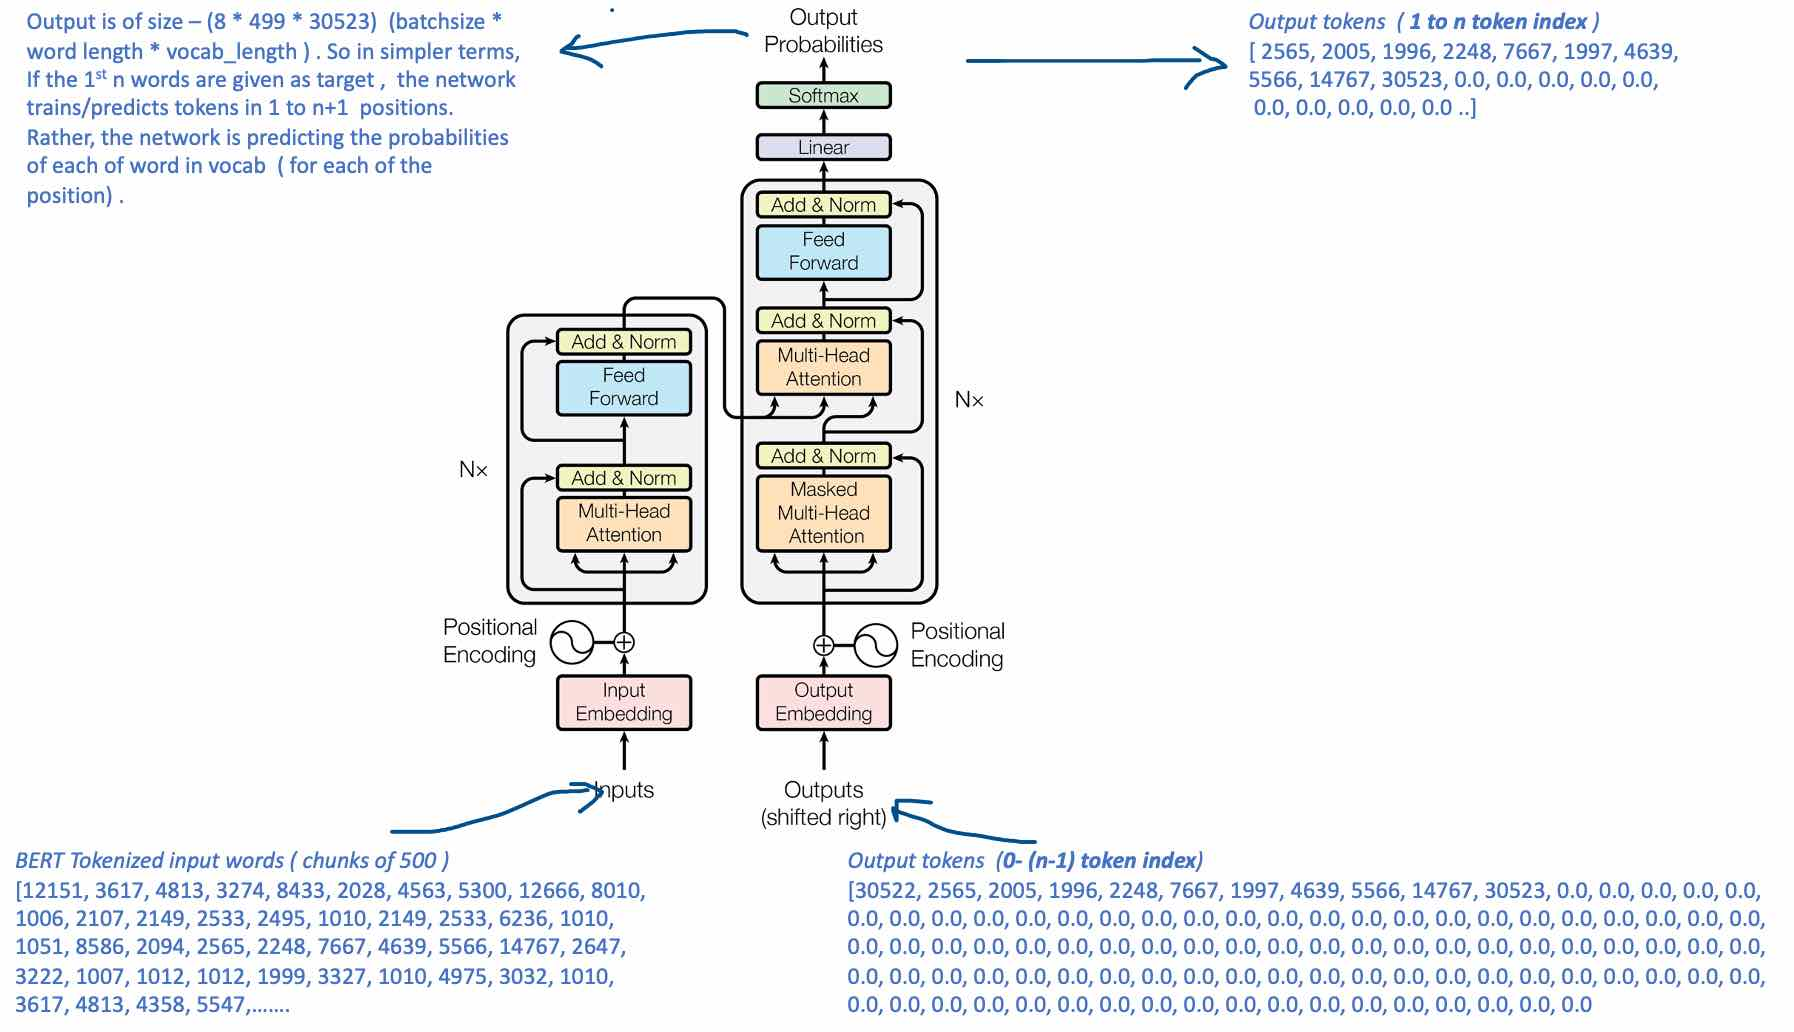

Original image taken from : https://arxiv.org/abs/1706.03762

In [ ]:
##
# Define the transformer model 
##

import torch.nn as nn 

class FFN(nn.Module):
    def __init__(self, state_size=EMBEDDING_DIM):
        super(FFN, self).__init__()
        self.state_size = state_size
        self.lr1 = nn.Linear(state_size, state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(state_size, state_size)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        return self.dropout(x)

def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

class ColleridgeTransformerModel(nn.Module):

    def __init__(self, input_vocab_len , output_vocab_len,embed_dim = EMBEDDING_DIM, max_seq=MAX_SEQ): 
        super(ColleridgeTransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(input_vocab_len, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq, embed_dim)
        self.e_embedding = nn.Embedding(output_vocab_len, embed_dim)
        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.layer_normal = nn.LayerNorm(embed_dim) 
        self.ffn = FFN(embed_dim)
        self.pred = nn.Linear(embed_dim, output_vocab_len)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, generated_words):
        device = x.device       
        
        # Embed the token
        x = self.embedding(x)
        
        # Calculate the position id and embed it
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)
        
        #Add it to the poisition id
        pos_x = self.pos_embedding(pos_id)
        x = x + pos_x
        
        # This is the target_id/query ( right shifted input )
        e = self.e_embedding(generated_words) 
        pos_e_id = torch.arange(e.size(1)).unsqueeze(0).to(device)
        pos_e = self.pos_embedding(pos_e_id)
        e = e + pos_e
         
        # Send the query key and value to the multi attention network 
        x = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        att_output, att_weight = self.multi_att(x, x, x)
        x = self.layer_normal(att_output + x)
        
        
        for i in range ( 0, 1):
            
            e = e.permute(1, 0, 2)
              
            att_mask = future_mask(e.size(0)).to(device) 

            # Send the query key and value to the multi attention network 
            att_output, att_weight = self.multi_att(e, e, e, attn_mask=att_mask)

            e = self.layer_normal(att_output + e)

            # Send the query key and value to the multi attention network 
            att_output, att_weight = self.multi_att(e, x, x)

            # Normalization 
            att_output = self.layer_normal(att_output + e)

            # Reshape the output
            att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]

            # Send the output to FFN.
            e = self.ffn(att_output)

            # Normalize
            e = self.layer_normal(e + att_output)
        
        # predict the output string 
        e = self.pred(e)
        # Softmax the output string
        e = self.softmax(e)
        e = e.permute(0, 2, 1)
        return e, att_weight

In [ ]:
##
# Create the dataset class that will be used in the training 
##

from torch.utils.data import Dataset, DataLoader

class ColleridgeDataset(Dataset):
    def __init__(self, df, max_seq=MAX_SEQ):
        super(ColleridgeDataset, self).__init__()
        self.max_seq = max_seq
        self.samples = df

    def __len__(self):
        #print(len(self.samples.index) )
        return len(self.samples.index)
    
    def __pair_to_tensor__(self, pair):
        input_tensor = torch.tensor(pair[0] , dtype=torch.int, device=device).view(-1, 1) 
        target_tensor = torch.tensor(pair[1], dtype=torch.int, device=device).view(-1, 1) 
        return (input_tensor, target_tensor)
    
    def __getitem__(self, index):
        x, y = self.__pair_to_tensor__( (self.samples.iloc[index]['text'], self.samples.iloc[index]['code']) )
        target_id = y[:-1]
        label = y[1:]
        #print(target_id.squeeze(-1)[0:10])
        return  x.squeeze(-1), target_id.squeeze(-1), label
##
# This method trains the model with the iterator data for ONE epoch. 
##
from sklearn.metrics import roc_auc_score
def train_epoch(model, train_iterator, optim, criterion, device="cpu"):
    model.train()

    train_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []

    tbar = tqdm(train_iterator)
    for item in tbar:
        x = item[0].to(device).long()
        target_id = item[1].to(device).long()
        label = item[2].to(device).long() 

        # Reset the gradients before invoking the 'forward' again
        optim.zero_grad()
        
        # Invoke the 'forward' of the model
        output, atten_weight = model(x, target_id)
        
        # compute the loss with the actual and computed value
        loss = criterion(output , label.squeeze(-1) )

        # when we call loss.backward(), the whole graph is 
        # differentiated w.r.t. the loss, and all Variables in the graph will have their 
        # .grad Variable accumulated with the gradient.
        loss.backward()
        
        # move forward the optimizer
        optim.step()
        
        # For display :
        train_loss.append(loss.item())

        tbar.set_description('loss - {:.4f}'.format(loss))

    loss = np.mean(train_loss)

    return loss

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(6, shuffle=True, random_state=1)
for train, test in kfold.split(range(0,len(larger_label_set))):
    label_set = known_labels[train]
    break

label_set

In [ ]:
## #  Create a dataset that will provide the data for validation. Please note the 'target', initially, contains only the encoding for [cls] token 
#  Each generated ouput token in the previous cycle will be added to the target for the next prediction cycle.
# 
##

from torch.utils.data import Dataset, DataLoader
class ColleridgeDatasetEval(Dataset):
    def __init__(self, df, max_seq=MAX_SEQ):
        super(ColleridgeDatasetEval, self).__init__()
        self.max_seq = max_seq
        self.samples = df

    def __len__(self):
        return len(self.samples.index)
    
    def __getitem__(self, index):
        x = torch.tensor(self.samples.iloc[index]['text'], dtype=torch.int, device=device).view(-1, 1)
        y = torch.tensor(np.zeros(MAX_SEQ), dtype=torch.int, device=device).view(-1, 1)
        y[0] = 30522
        target_id = y[:-1]
        
        #label = torch.tensor(self.samples.iloc[index]['code'], device=device).view(1,-1).tolist()
        return  x.squeeze(-1), target_id.squeeze(-1), np.array( self.samples.iloc[index]['code'] )  , self.samples.iloc[index]['Id']
    
##
# Validate the model with unseen data and return the fbeta score 
##

def validate_model (model,dataloader,device ):

    num=0

    df_eval = pd.DataFrame(columns = ['id', 'predicted', 'truth'])
    model.eval()

    all_labels = []
    correctly_predicted_labels = []
    for item in tqdm(dataloader):
        stop = False 
        i = 0
        while ( i < MAX_SEQ-2 ):
            output,_ = model( item[0].to(device).long(),item[1].to(device).long()  )
            y = torch.argmax( output , dim=1)
            z = y[0][i]
            item[1][0][i+1]=z
            i = i+1
            if ( z == 0):
                break
        y = [30522] + y.tolist()[0]

        pred_string = tokenizer.convert_tokens_to_string (tokenizer.convert_ids_to_tokens([int(z) for z in y if z not in [30522, 0, 0.0, 0 ]]))
        text = tokenizer.convert_tokens_to_string (tokenizer.convert_ids_to_tokens([z for z in item[0].tolist()[0] if z not in [30522, 0, 0.0, 0 ]]))

        labels = tokenizer.convert_tokens_to_string (tokenizer.convert_ids_to_tokens([int(z) for z in item[2].tolist()[0] if z not in [30522, 0, 0.0, 0 ]]))
        
        
        for label in labels.split('[sep]'):
            #label = tokenizer.convert_tokens_to_string (tokenizer.convert_ids_to_tokens([int(z) for z in label if z not in [30522, 30523, 0.0, 0 ]]))
            if( label.strip() not in label_set and label != "" ):
                df_temp = pd.DataFrame ({"id":item[3],  "predicted": [''] , 'truth': [label]  }, index=[num])
                df_eval =df_eval.append(df_temp, ignore_index=True)
                all_labels.append(label.strip())
        
        
        for index, pred_label in enumerate ( pred_string.split('[sep]') )   : 
            if ( text.find(pred_label) != -1 ):
                if( pred_label.strip() not in label_set and pred_label != "" ):
                    correctly_predicted_labels.append(pred_label.strip())
                    df_temp = pd.DataFrame ({"id":item[3],  "predicted": [pred_label], 'truth': [''] }, index=[num])
                    df_eval =df_eval.append(df_temp, ignore_index=True)
           
            
        num = num+1
        
    correctly_predicted_labels = np.unique(correctly_predicted_labels)
    all_labels = np.unique(all_labels)
    
    print("Correctly Predicted:" )
    print(correctly_predicted_labels)
    
    print("Missed to Predict:" )
    print( list( set(all_labels) - set(correctly_predicted_labels)) ) 
    
    #df_eval = df_eval.reset_index()
    #print(df_eval)

    #df_eval ['truth_string'] = df_eval['truth'].apply(lambda r: "|".join(tokenizer.convert_tokens_to_string \
    #                    (tokenizer.convert_ids_to_tokens([int(z) for z in r if z not in [30522, 0.0, 0 ]] )).split('[sep]')) )
    #df_eval ['predicted_string'] = df_eval['predicted'].apply(lambda r: "|".join(tokenizer.convert_tokens_to_string (tokenizer.convert_ids_to_tokens( [int(z) for z in r if z not in [30522, 0.0, 0]] ) ).split('[sep]')))
    df_result=df_eval.groupby('id').apply(lambda row: (  "|".join(np.unique("|".join(row['truth'].values).split("|"))), \
                                                       "|".join( np.unique( "|".join(row['predicted'].values).split("|")) ) ) )
        
    #print(df_result.values)   
    
    df_final_result = pd.DataFrame(columns = ['id', 'predicted', 'truth'])
    df_final_result['id'] = df_result.index
    
    df_final_result['truth'] = list(map(lambda row:  "|".join( string for string in row[0].split("|") if string != "") ,  df_result.values ))
    df_final_result['predicted'] =list(map(lambda row: "|".join( string for string in row[1].split("|") if string != ""),  df_result.values ))


    #print(df_final_result)
    
    return ( compute_fbeta(df_final_result['truth'].apply(lambda x: x.split('|')), 
                           df_final_result['predicted'].apply(lambda x: x.split('|')),\
                           0.5) )





In [ ]:
"""Compute the Jaccard-based micro FBeta score.

    References
    ----------
    - https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/overview/evaluation
    - https://www.kaggle.com/armandmorin/matching-baseline-mlm-w-evaluation-metric
"""
def compute_fbeta(y_true,
                  y_pred,
                  beta) -> float:
    """Compute the Jaccard-based micro FBeta score.

    References
    ----------
    - https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/overview/evaluation
    """

    def _jaccard_similarity(str1 , str2 ) :
        #print(str1+"XXXX"+str2)
        a = set(str1.split()) 
        b = set(str2.split())
        c = a.intersection(b)
        if ( len(a) + len(b) +len(c) == 0) :
            return 0.0
        else:
            return float(len(c)) / (len(a) + len(b) - len(c)+1)

    tp = 0.000001  # true positive
    fp = 0.000001  # false positive
    fn = 0.000001  # false negative
    for ground_truth_list, predicted_string_list in zip(y_true, y_pred):
        
        #print(predicted_string_list)
        #print(ground_truth_list)
        #print("XXX")
           
        predicted_string_list_sorted = sorted(predicted_string_list)
        for ground_truth in sorted(ground_truth_list):     

            if len(predicted_string_list_sorted) == 0:
                fn += 1
            else:
                similarity_scores = [
                    _jaccard_similarity(ground_truth, predicted_string)
                    for predicted_string in predicted_string_list_sorted
                ]
                matched_idx = np.argmax(similarity_scores)
                if similarity_scores[matched_idx] >= 0.5:
                    predicted_string_list_sorted.pop(matched_idx)
                    tp += 1
                else:
                    #print("false negative")
                    fn += 1
        fp += len(predicted_string_list_sorted)

    

    tp *= (1 + beta ** 2)
    fn *= beta ** 2
    fbeta_score = tp / (tp + fp + fn)
    return fbeta_score

In [ ]:
'''tokenizer.convert_tokens_to_string (tokenizer.convert_ids_to_tokens( \
                        df_train_new[ ((df_train_new['word_count']==0) & (df_train_new['rseq_no']< 5)) == True ].iloc[7]['text']))'''

In [ ]:
##
# Training and Validating the model
##

from tqdm import tqdm 
from sklearn.model_selection import KFold


unique_ids = df_train['Id'].unique()
kfold = KFold(6, shuffle=True, random_state=1)
curr_best_cv_score = -1
cv_score_sum=0

cv_iter=0

if ( TRAINING_MODE ==  "TRAIN_FROM_SCRATCH" ):
        
    for train, test in kfold.split(range(0,len(larger_label_set))):

        #train_ids = [unique_ids[x] for x in train]
        train_ids = [idx for idx in train_new.index for truth in train_new[idx] if truth  in known_labels[train]  ]
        df_train_new =  df_train[df_train['Id'].isin(train_ids) ].copy()
        
        #val_ids = [unique_ids[x] for x in test]
        val_ids = [idx for idx in train_new.index for truth in train_new[idx] if truth  in known_labels[test]  ]
        df_val_new = df_train[df_train['Id'].isin(val_ids)].copy()
        df_val_new = df_val_new.reset_index()
        print(df_val_new.shape)

        xfrmer_model = ColleridgeTransformerModel( vocab_len ,vocab_len )
        xfrmer_model.to(device)
        
        # Ensure that the data is balanced with rows which has study and the ones without. 
        pos_samples = df_train_new[ df_train_new['word_count']!=0 ] 
        neg_samples = df_train_new[ ((df_train_new['word_count']==0) & (df_train_new['rseq_no']< 10)) == True ] 
        neg_samples = neg_samples [:pos_samples.shape[0]]
        print(pos_samples.shape[0], neg_samples.shape[0])
        df_train_new =  pos_samples.append ( neg_samples ) 
        df_train_new = df_train_new.reset_index()
        #print(df_train_new.shape)
        
        #print(df_train_new.index)

        train_dataset = ColleridgeDataset(df_train_new)
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

        val_dataset = ColleridgeDatasetEval(df_val_new)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

        optimizer = torch.optim.Adam(xfrmer_model.parameters(), lr=LEARNING_RATE)
        criterion = nn.NLLLoss(reduction="sum")
        criterion.to(device)
        

        for epoch in range(EPOCHS):
            loss = train_epoch(xfrmer_model, train_dataloader, optimizer, criterion, device)
            print("epoch - {} train_loss - {:.2f} ".format(epoch, loss))

        cv_score = validate_model (xfrmer_model,val_dataloader, device)
        print(cv_score)
        cv_score_sum = cv_score_sum + cv_score
        print(cv_score_sum)

        if( cv_score > curr_best_cv_score):
            curr_best_cv_score = cv_score
            torch.save(xfrmer_model.state_dict(), "xform-17.model")
            
        cv_iter = cv_iter+1
        if(cv_iter>2):
            break


    print ("average score = ", cv_score_sum/3)  
    print( "best score = ", cv_score)

## Prediction

For Prediction - the input work tokens along with target ( just encoded [cls] token ) is provided to the trained network. This will generate the next output token. This is then appeneded and provided as target in the next iteration. This process is repeated till no more new tokens are generated.

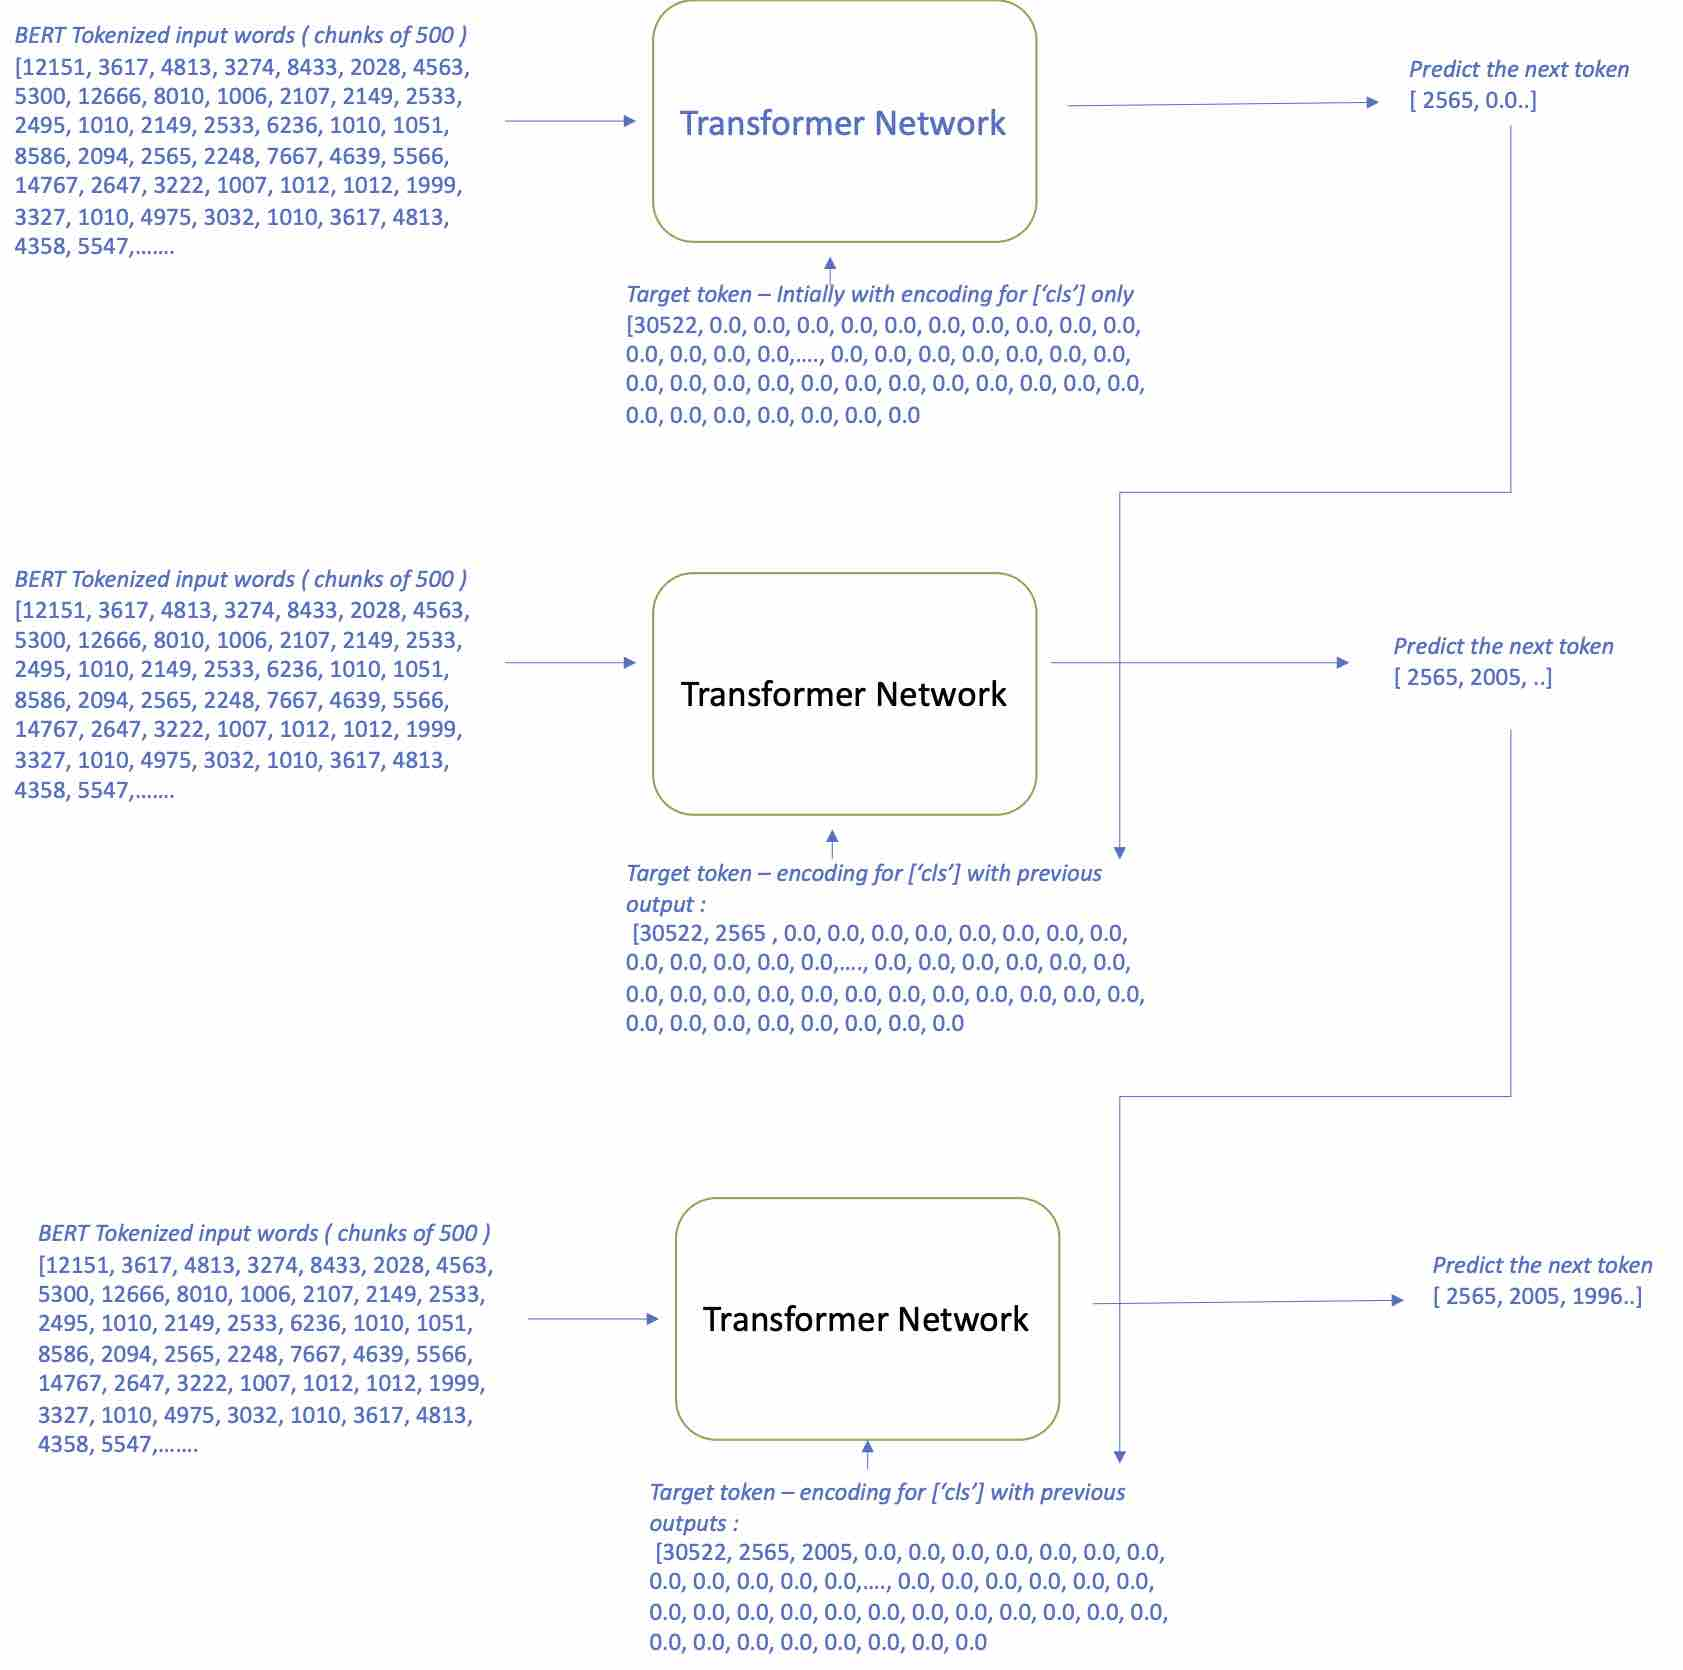

In [ ]:
'''df_test = process_data(train_new[6000:6200], tokenizer)
df_test = df_test.reset_index()'''

In [ ]:
'''df_test'''

In [ ]:
'''test_dataset = ColleridgeDatasetEval(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)'''

In [ ]:
'''xfrmer_model = ColleridgeTransformerModel( vocab_len ,vocab_len )
xfrmer_model.to(device)
xfrmer_model.load_state_dict(torch.load('../input/model17/xform-17.model', map_location=device))
validate_model (xfrmer_model,test_dataloader, device)'''